In [2]:
# Dataset
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.datasets import boston_housing

In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

57026/57026 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


In [5]:
print(train_data.shape)
print(train_targets.shape)

(404, 13)
(404,)


In [6]:
print(test_data.shape)
print(test_targets.shape)

(102, 13)
(102,)


In [8]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [9]:
test_data[0]

array([ 18.0846,   0.    ,  18.1   ,   0.    ,   0.679 ,   6.434 ,
       100.    ,   1.8347,  24.    , 666.    ,  20.2   ,  27.25  ,
        29.05  ])

In [10]:
train_targets[0]

np.float64(15.2)

In [11]:
test_targets[0]

np.float64(7.2)

In [12]:
np.max(train_targets)

np.float64(50.0)

In [13]:
np.max(test_targets)

np.float64(50.0)

In [14]:
# feature-wise Normalizing the data
mean = train_data.mean(axis = 0)
print(mean.shape)

(13,)


In [15]:
print(mean)

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]


In [16]:
train_data -= mean

In [17]:
train_data.shape

(404, 13)

In [18]:
std = train_data.std(axis = 0)
train_data /= std


In [19]:
test_data -= mean
test_data /= std

In [20]:
test_data.shape

(102, 13)

In [21]:
def build_model():
  model = keras.Sequential([
      layers.Dense(64, activation = "relu"),
      layers.Dense(64, activation = "relu"),
      layers.Dense(1)
  ])

  model.compile(
      optimizer = "rmsprop",
      loss = "mse",
      metrics = ["mae"]
  )

  return model

In [ ]:
# K-folds cross validation


"""
i = 0
val_data[0:101]
partial_train_data = train_data[101:]

i = 1
val_data[101:202]
partial_train_data = train_data[0:101], train_data[202:]

i = 2
val_data[202:303]
partial_train_data = train_data[:202], train_data[303:]

i = 3
val_data[303:404]
partial_train_data = train_data[0:303], train_data[404:404]

for each fold, model is trained for 100 epochs on training dataset
"""
k = 4
num_val_samples = len(train_data) // 4
num_epochs = 100
all_scores = []
print(len(train_data))
print(num_val_samples)
for i in range(k):
  print(f"Fold being processed: #{i}")
  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i+1) * num_val_samples: ]], axis = 0)
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples], train_targets[(i+1) * num_val_samples:]], axis = 0)

  model = build_model()

  model.fit(partial_train_data, partial_train_targets, epochs = num_epochs, batch_size = 16, verbose = 0)

  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)

  all_scores.append(val_mae)

print(all_scores)
print()
print(np.mean(all_scores))

404
101
Fold being processed: #0
Fold being processed: #1
Fold being processed: #2
Fold being processed: #3
[2.04693603515625, 2.4631247520446777, 2.446840763092041, 2.430683135986328]

2.346896171569824


In [ ]:
print(train_targets.shape)
print(type(train_targets))

(404,)
<class 'numpy.ndarray'>


In [ ]:
# Saving the validation log at each fold

num_epochs = 500

all_mae_histories = []

for i in range(k):

  val_data = train_data[i * num_val_samples: (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples], train_data[(i+1)* num_val_samples:]], axis = 0)
  partial_train_targets = np.concatenate([train_targets[: i* num_val_samples], train_targets[(i+1) * num_val_samples: ]], axis = 0)


  print(f"Fold {i}")
  #print(f"val_data shape: {val_data.shape}")
  #print(f"val_targets shape: {val_targets.shape}")
  #print(f"partial_train_data shape: {partial_train_data.shape}")
  #print(f"partial_train_targets shape: {partial_train_targets.shape}")

  model = build_model()
  # 4 different models are trained for each i in k

  history = model.fit(partial_train_data, partial_train_targets,
                      batch_size=16, epochs = num_epochs,
                      validation_data = (val_data, val_targets), verbose = 0)

  # one list per fold containing per epoch values of val_mae
  mae_history = history.history["val_mae"] # validation MAE values recorded at the end of each epoch for this fold
  # 4 folds and 500 epochs
  # [
  # [val_mae_epoch_0_fold_0, val_mae_epoch_1_fold_0, .., val_mae_epoch_499_fold_0],
  # [val_mae_epoch_0_fold_1, val_mae_epoch_1_fold_1, ..., val_mae_epoch_499_fold_1],
  #..
  # [val_mae_epoch_0_fold_3, val_mae_epoch_1, fold_3, ..., val_mae_epoch_499_fold_3]
  # ]
  all_mae_histories.append(mae_history)


Fold 0
Fold 1
Fold 2
Fold 3


In [ ]:
# Average of the per-epoch MAE scores for all folds

# extract the MAE at epoch i across all folds and then calculate the mean of those MAEs
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
# average validation MAE at each epoch i across all folds

500


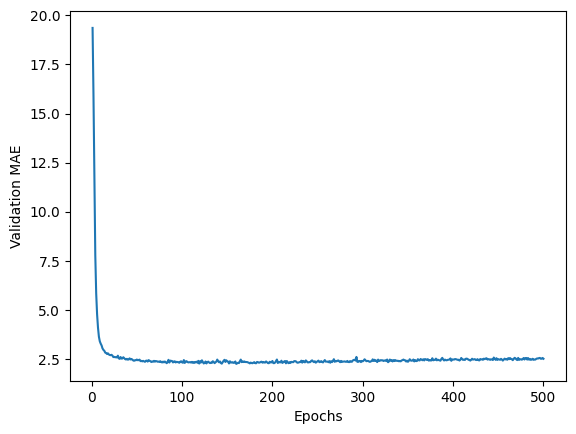

In [ ]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

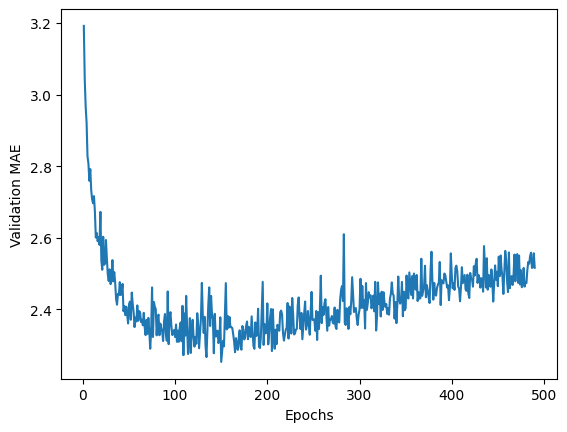

In [ ]:
truncated_mae_history = average_mae_history[10:]
plt.plot(range(1, len(truncated_mae_history) + 1), truncated_mae_history)
plt.xlabel("Epochs")
plt.ylabel("Validation MAE")
plt.show()

In [ ]:
model = build_model()

In [ ]:
model.fit(train_data, train_targets, epochs = 130, batch_size = 16, verbose = 0)


In [ ]:
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 10.0764 - mae: 2.1625


In [ ]:
test_mae_score

2.3128552436828613

In [ ]:
predictions = model.predict(test_data)
predictions[0]

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


array([7.6287036], dtype=float32)